In [12]:
import torch
from omegaconf import DictConfig
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

import numpy as np
import os

from tsl import logger
from tsl.data import ImputationDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PemsBay
from tsl.engines import Imputer
from tsl.experiment import Experiment
from tsl.metrics import numpy as numpy_metrics
from tsl.metrics import torch as torch_metrics
from tsl.nn.models import (BiRNNImputerModel, GRINModel, RNNImputerModel,
                           SPINHierarchicalModel, SPINModel)
from tsl.ops.imputation import add_missing_values
from tsl.transforms import MaskInput
from tsl.utils.casting import torch_to_numpy

from omegaconf import OmegaConf

from my_datasets import AirQualitySmaller, AirQualityAuckland


In [13]:
def get_model_class(model_str):
    if model_str == 'rnni':
        model = RNNImputerModel
    elif model_str == 'birnni':
        model = BiRNNImputerModel
    elif model_str == 'grin':
        model = GRINModel
    elif model_str == 'spin':
        model = SPINModel
    elif model_str == 'spin-h':
        model = SPINHierarchicalModel
    else:
        raise NotImplementedError(f'Model "{model_str}" not available.')
    return model


def get_dataset(dataset_name: str, p_fault=0., p_noise=0., masked_s=None):
    if dataset_name == 'air':
        return AirQuality(impute_nans=True, small=True, masked_sensors=masked_s)
    if dataset_name == 'air_smaller':
        return AirQualitySmaller('../../../AirData/AQI/Stations', impute_nans=True, masked_sensors=masked_s)
    if dataset_name == 'air_auckland':
        return AirQualityAuckland('../../../AirData/Niwa', t_range=['2022-04-01', '2022-12-01'], masked_sensors=masked_s)
    if dataset_name.endswith('_point'):
        p_fault, p_noise = 0., 0.25
        dataset_name = dataset_name[:-6]
    if dataset_name.endswith('_block'):
        p_fault, p_noise = 0.0015, 0.05
        dataset_name = dataset_name[:-6]
    if dataset_name == 'la':
        return add_missing_values(MetrLA(),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  seed=9101112)
    if dataset_name == 'bay':
        return add_missing_values(PemsBay(),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  seed=56789)
    raise ValueError(f"Dataset {dataset_name} not available in this setting.")

In [14]:
def load_model_and_infer(og_path: str):
    result = []
    for root, dirs, files in os.walk(og_path):
        for name in files:
            if 'ckpt' in name:
                result.append(os.path.join(root, name))
    
    assert len(result)
    checkpoint_path = result[0]
    
    # Load configuration
    cfg = OmegaConf.load(os.path.join(og_path, 'config.yaml'))
    
    # Load dataset
    dataset = get_dataset(cfg.dataset.name, masked_s=cfg.dataset.masked_sensors)
    covariates = {'u': dataset.datetime_encoded('day').values}
    adj = dataset.get_connectivity(**cfg.dataset.connectivity)
    
    torch_dataset = ImputationDataset(
        target=dataset.dataframe(),
        mask=dataset.training_mask,
        eval_mask=dataset.eval_mask,
        covariates=covariates,
        transform=MaskInput(),
        connectivity=adj,
        window=cfg.window,
        stride=cfg.stride
    )
    
    scalers = {'target': StandardScaler(axis=(0, 1))}

    dm = SpatioTemporalDataModule(
        dataset=torch_dataset,
        scalers=scalers,
        splitter=dataset.get_splitter(**cfg.dataset.splitting),
        batch_size=cfg.batch_size,
        workers=cfg.workers)
    
    dm.setup(stage='test')
    
    # Load model
    model_cls = get_model_class(cfg.model.name)
    model_kwargs = {
        'n_nodes': torch_dataset.n_nodes,
        'input_size': torch_dataset.n_channels,
        'exog_size': torch_dataset.input_map.u.shape[-1]
    }
    model_cls.filter_model_args_(model_kwargs)
    model_kwargs.update(cfg.model.hparams)

    trainer = Trainer(
        max_epochs=cfg.epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=[0])
    
    imputer = Imputer.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs)
    imputer.eval()

    # trainer.test(imputer, datamodule=dm)
    
    # # Run inference
    # trainer = torch.utils.data.DataLoader(dm.test_dataloader(), batch_size=cfg.batch_size)
    output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
    output = imputer.collate_prediction_outputs(output)
    output = torch_to_numpy(output)
    
    y_hat, y_true, mask = (output['y_hat'], output['y'],
                           output.get('eval_mask', None))
    res = dict(test_mae=numpy_metrics.mae(y_hat, y_true, mask),
               test_mre=numpy_metrics.mre(y_hat, y_true, mask),
               test_mape=numpy_metrics.mape(y_hat, y_true, mask))
    
    return y_hat, y_true, mask, res, dm, dataset


In [21]:
checkpoint_path = '../logs/grin/air_auckland/2025-02-14/19-54-32'  # Path to model checkpoint
y_hat, y_true, mask, res, dm, dataset = load_model_and_infer(checkpoint_path)
res

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]
/home/mala711/GNNstuff/GNNthesis/pipenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]

Only args ['edge_weight', 'mask', 'edge_index', 'x', 'u'] are forwarded to the model (GRINModel).


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 12.98it/s]


{'test_mae': 3.28034, 'test_mre': 0.552224468612795, 'test_mape': 0.8029063}

In [22]:
np.sum(dataset.eval_mask[:, 5, :])

0

In [23]:
torch.sum(dm.mask[:, 5, :])

tensor(4898)

In [24]:
y_hat.shape

(1477, 12, 6, 1)

In [25]:
graph_hat = y_hat.reshape(y_hat.shape[0]*y_hat.shape[1], y_hat.shape[2], y_hat.shape[3])
graph_true = y_true.reshape(y_true.shape[0]*y_true.shape[1], y_true.shape[2], y_true.shape[3])

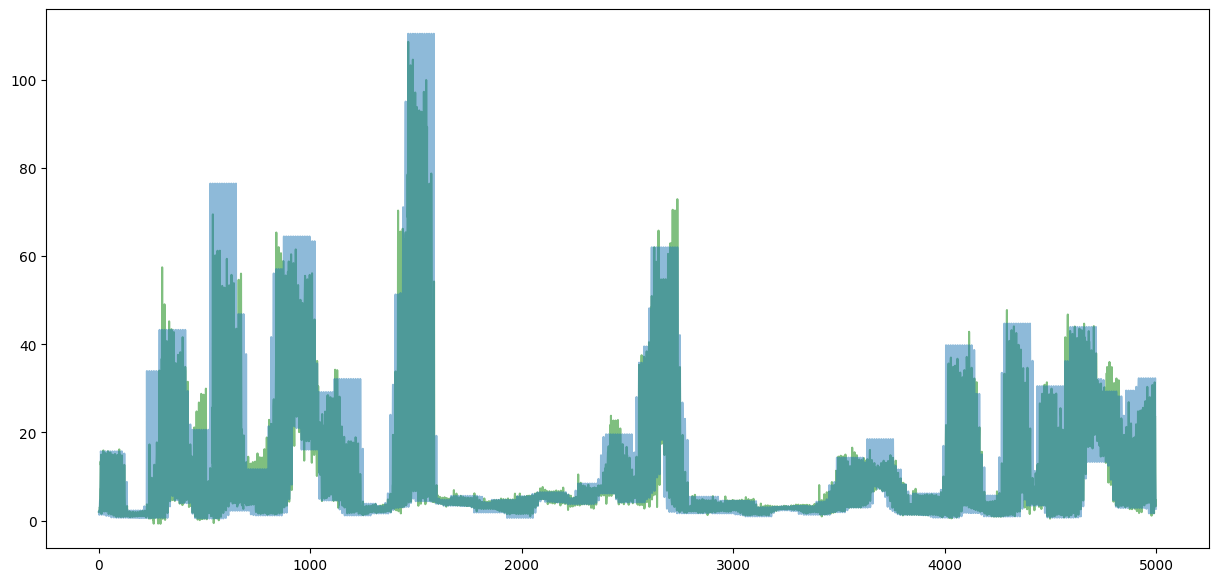

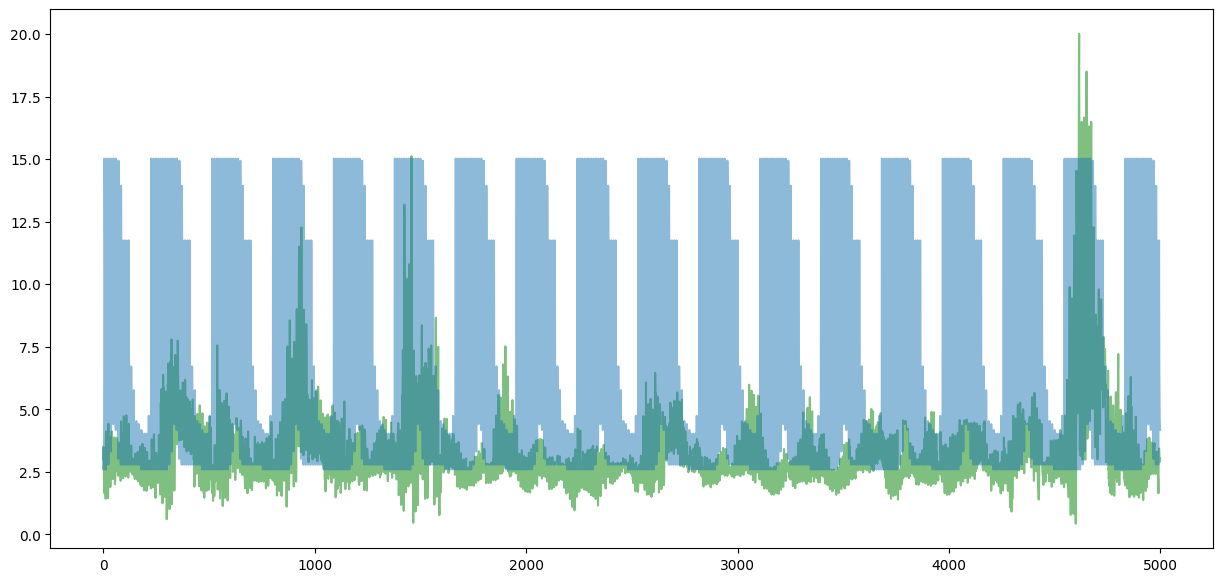

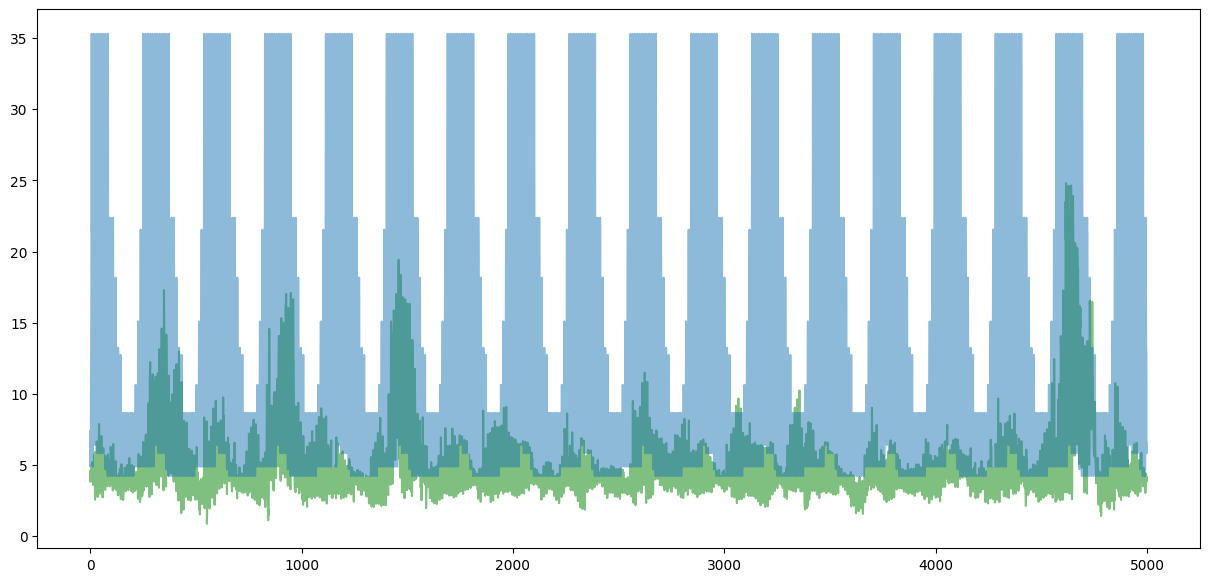

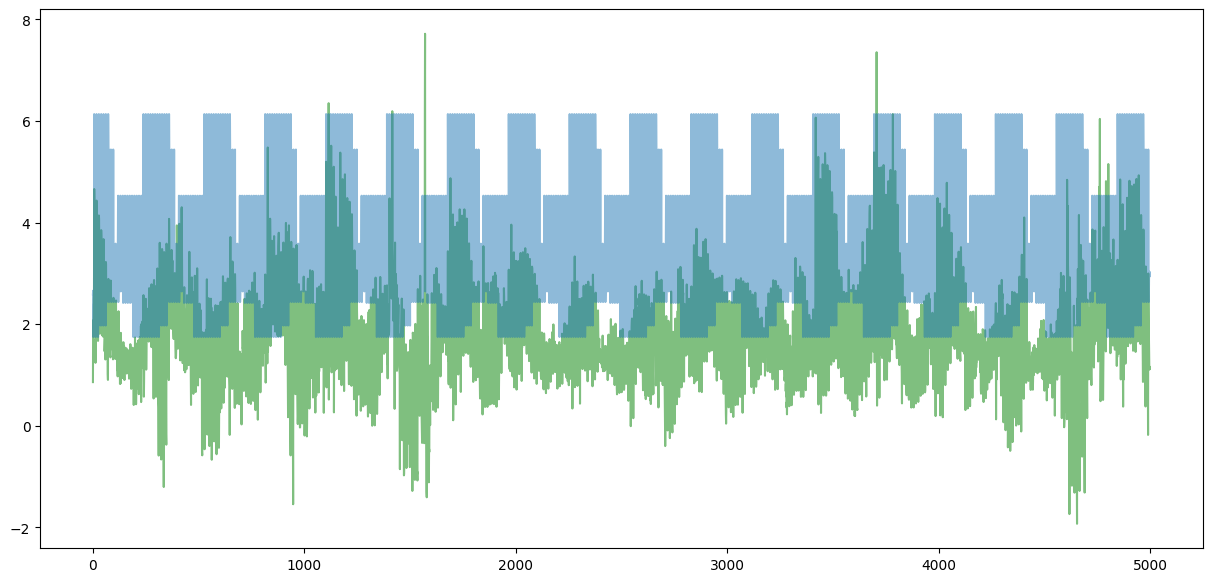

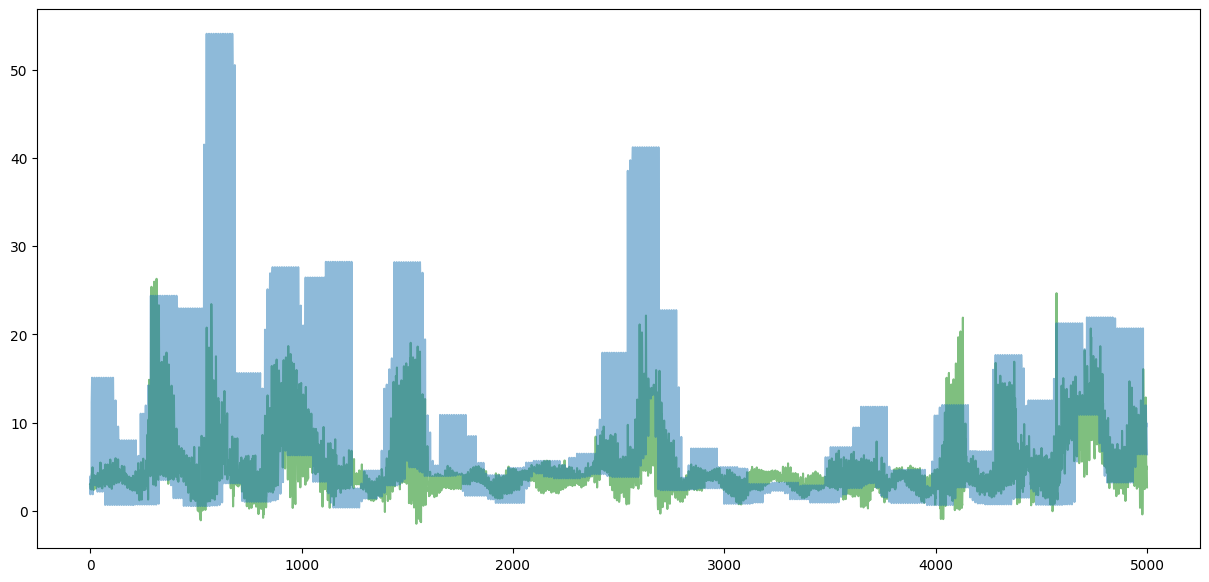

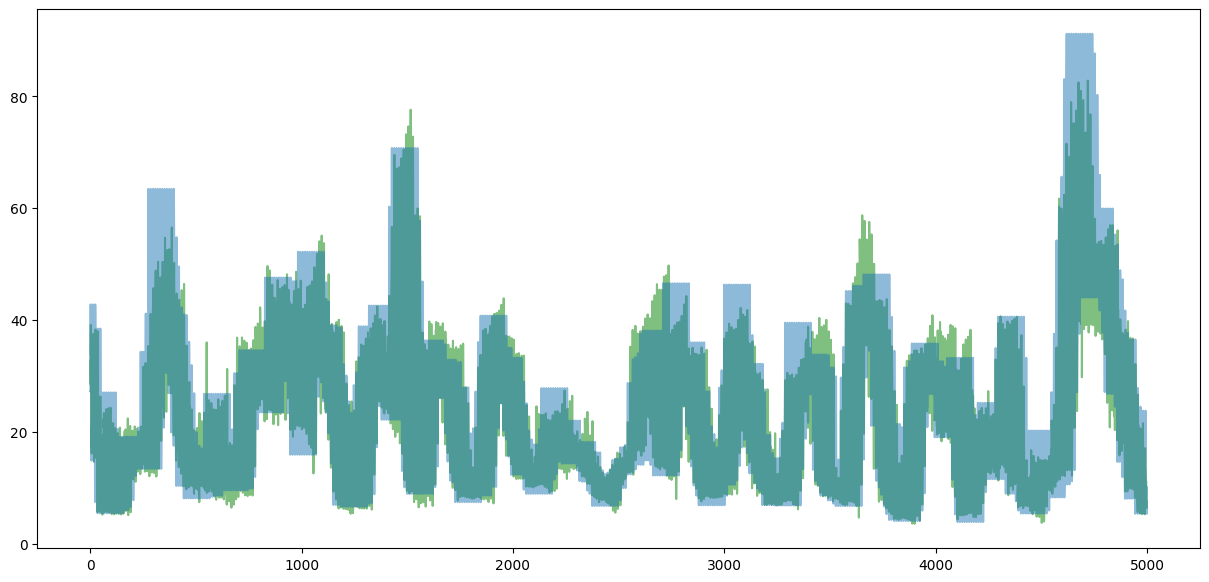

In [26]:
import matplotlib.pyplot as plt

ranges = [0, 5000]
for i in range(y_hat.shape[2]):
    plt.figure(figsize=(15,7))
    plt.plot(graph_hat[ranges[0]:ranges[1], i, 0], color='g', alpha=0.5)
    plt.plot(graph_true[ranges[0]:ranges[1], i, 0], alpha=0.5)
    plt.show()